In [28]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-wqw52hfl
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-wqw52hfl
  Resolved https://github.com/albumentations-team/albumentations to commit 8f3df5110a364163dfde1f2e808737868cea84cf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [30]:
train_path = f'/content/Facial-Expression-Dataset/train'
test_path = f'/content/Facial-Expression-Dataset/validation'

In [31]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [32]:
LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15
DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_bo'

In [33]:
train_augs = T.Compose ([
    T.RandomHorizontalFlip (p =0.5),
    T.RandomRotation (degrees = (-20,+20)),
    T.ToTensor() # (h,w,c) > (c,h,w)
])
valid_augs = T.Compose ([
    T.ToTensor()
])

In [34]:
trainset = ImageFolder (train_path , transform = train_augs)
validset = ImageFolder (test_path , transform = valid_augs)

In [35]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [36]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


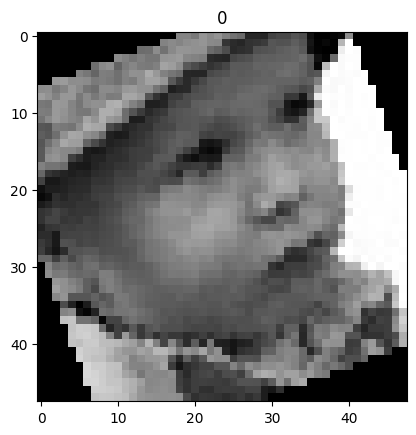

In [37]:
image , label = trainset[20]
plt.imshow(image.permute (1,2,0))
plt.title(label);

In [38]:
from torch.utils.data import DataLoader

In [39]:
trainloader = DataLoader (trainset, batch_size = BATCH_SIZE , shuffle = True)
validloader = DataLoader (validset, batch_size = BATCH_SIZE)

In [40]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [41]:
for images , labels in trainloader:
  break;

print(f"One image batch shape : {images.shape}") #number of images,c,h,w
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


#  Model

In [42]:
import timm
from torch import nn

In [43]:
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel, self).__init__()
    self.eff_net = timm.create_model('efficientnet_b0' , pretrained =True, num_classes = 7)
  def forward(self, images, labels = None):
    logits = self.eff_net(images)
    if labels != None:
      loss = nn.CrossEntropyLoss()(logits,labels)
      return logits,loss
    return logits

In [44]:
model = FaceModel()
model.to(DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 

In [45]:
from tqdm import tqdm

In [46]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [47]:
def train_fn(model, dataloader, optimizer, current_epo):
  model.train()
  total_loss =0.0
  total_acc =0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]"+str(current_epo + 1 ) + "/" +str(EPOCHS))
  for t,data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE) , labels.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model (images , labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss /(t+1)) , 'accuracy' : '%6f' %float(total_acc /(t+1)) })

  return total_loss/len(dataloader) , total_acc/len(dataloader)

In [48]:
def eval_fn(model, dataloader, current_epo):
  model.eval()
  total_loss =0.0
  total_acc =0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[VALID]"+str(current_epo + 1 ) + "/" +str(EPOCHS))
  for t,data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE) , labels.to(DEVICE)

    logits, loss = model (images , labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss /(t+1)) , 'accuracy' : '%6f' %float(total_acc /(t+1)) })

  return total_loss/len(dataloader) , total_acc/len(dataloader)

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr =LR)

In [50]:
best_valid_loss = np.inf
for i in range (EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader,optimizer,i)
  valid_loss , valid_acc = eval_fn (model, validloader, i )
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), ' best-weights.pt')
    print("saved_best_weights")
    best_valid_loss = valid_loss


EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:07<00:00, 30.05it/s, loss=1.716957, accuracy=0.448073]


saved_best_weights


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:07<00:00, 28.88it/s, loss=1.298591, accuracy=0.516294]


saved_best_weights


EPOCH[VALID]3/15: 100%|██████████| 221/221 [00:06<00:00, 32.64it/s, loss=1.198892, accuracy=0.552450]


saved_best_weights


EPOCH[VALID]4/15: 100%|██████████| 221/221 [00:06<00:00, 32.37it/s, loss=1.111146, accuracy=0.581046]


saved_best_weights


EPOCH[VALID]5/15: 100%|██████████| 221/221 [00:06<00:00, 32.51it/s, loss=1.067851, accuracy=0.588681]


saved_best_weights


EPOCH[VALID]7/15: 100%|██████████| 221/221 [00:06<00:00, 35.83it/s, loss=1.048661, accuracy=0.608728]


saved_best_weights


EPOCH[VALID]8/15: 100%|██████████| 221/221 [00:06<00:00, 34.02it/s, loss=1.035302, accuracy=0.612589]


saved_best_weights


EPOCH[VALID]11/15: 100%|██████████| 221/221 [00:09<00:00, 23.10it/s, loss=1.028054, accuracy=0.612633]


saved_best_weights


EPOCH[VALID]12/15: 100%|██████████| 221/221 [00:10<00:00, 21.58it/s, loss=1.007164, accuracy=0.622096]


saved_best_weights


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:06<00:00, 35.48it/s, loss=1.128838, accuracy=0.620671]


In [53]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

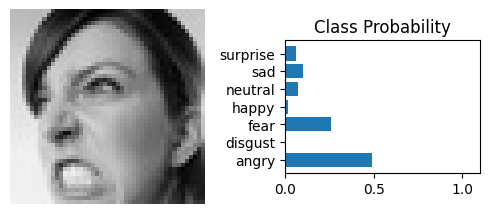

In [54]:
image ,  label = validset[97]
image = image.unsqueeze(0)
logits = model (image.to(DEVICE))
probs = nn.Softmax(dim = 1)(logits)
view_classify(image.squeeze(), probs)
